**Make sure you run this at the begining**

In [2]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

# Append template path to sys path
sys.path.append(os.getcwd() + "/template") 

In [3]:
from utils.load_data import load_data
from utils.load_data import log
from utils.visualize_tsp import plotTSP
from utils.tsp import TSP
from utils.tsp import TSP_Bench
from utils.tsp import TSP_Bench_ALL

# Workshop Starts Here

<img src="images/tsp.jpg" alt="TSP" style="width: 900px;"/>

<img src="images/solutions.png" alt="solutions" style="width: 900px;"/>

# Get familiar with your dataset

There are problems at different levels. **3 simple, 2 medium, 1 hard**.

In [4]:
for root, _, files in os.walk('./template/data'):
    if(files):
        for f in files:
            print(str(root) + "/" + f)

./template/data/medium/pcb442.tsp
./template/data/medium/a280.tsp
./template/data/hard/dsj1000.tsp
./template/data/simple/att48.tsp
./template/data/simple/ulysses16.tsp
./template/data/simple/st70.tsp


In [5]:
ulysses16 = np.array(load_data("./template/data/simple/ulysses16.tsp"))

In [6]:
ulysses16[:]

array([[38.24, 20.42],
       [39.57, 26.15],
       [40.56, 25.32],
       [36.26, 23.12],
       [33.48, 10.54],
       [37.56, 12.19],
       [38.42, 13.11],
       [37.52, 20.44],
       [41.23,  9.1 ],
       [41.17, 13.05],
       [36.08, -5.21],
       [38.47, 15.13],
       [38.15, 15.35],
       [37.51, 15.17],
       [35.49, 14.32],
       [39.36, 19.56]])

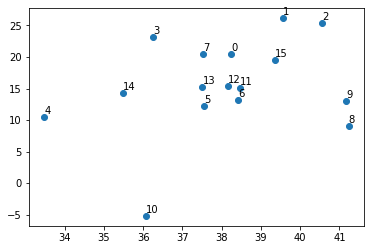

In [7]:
plt.scatter(ulysses16[:, 0], ulysses16[:, 1])
for i in range(0, 16):
    plt.annotate(i, (ulysses16[i, 0], ulysses16[i, 1]+0.5))

## Naive Solution: In Order

In [8]:
simple_sequence = list(range(0, 16))
print(simple_sequence)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


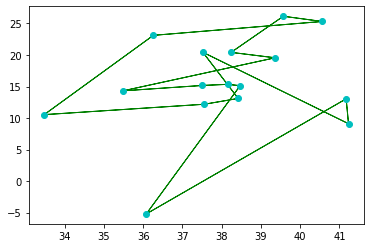

In [9]:
plotTSP([simple_sequence], ulysses16, num_iters=1)

## Naive Solution: Random Permutation

In [10]:
random_permutation = np.random.permutation(16).tolist()
print(random_permutation)

[11, 9, 14, 2, 15, 10, 0, 5, 3, 4, 7, 1, 12, 13, 6, 8]


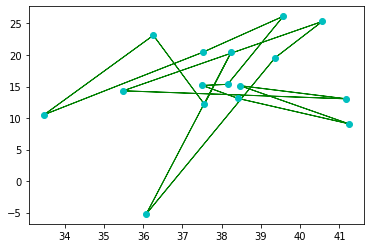

In [11]:
plotTSP([random_permutation], ulysses16, num_iters=1)

## Best Solution

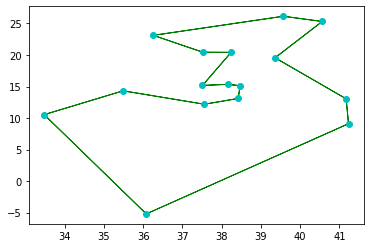

In [12]:
best_ulysses16 = [0, 13, 12, 11, 6, 5, 14, 4, 10, 8, 9, 15, 2, 1, 3, 7]
plotTSP([best_ulysses16], ulysses16, num_iters=1)

## Calculate Fitness (Sum of all Distances)

In [13]:
def dist(node_0, node_1, coords):
        """
        Euclidean distance between two nodes.
        """
        coord_0, coord_1 = coords[node_0], coords[node_1]
        return math.sqrt((coord_0[0] - coord_1[0]) ** 2 + (coord_0[1] - coord_1[1]) ** 2)

In [14]:
print("Coordinate of City 0:", ulysses16[0])

Coordinate of City 0: [38.24 20.42]


In [15]:
print("Coordinate of City 1:", ulysses16[1])

Coordinate of City 1: [39.57 26.15]


In [16]:
print("Distance Between", dist(0, 1, ulysses16))

Distance Between 5.882329470541408


In [17]:
def fitness(solution, coords):
    N = len(coords)
    cur_fit = 0
    for i in range(len(solution)):
        cur_fit += dist(solution[i % N], solution[(i + 1) % N], coords)
    return cur_fit

In [18]:
print ("Order Fitness:\t", fitness(simple_sequence, ulysses16))
print ("Random Fitness:\t", fitness(random_permutation, ulysses16))
print ("Best Fitness:\t", fitness(best_ulysses16, ulysses16))

Order Fitness:	 104.42225210207233
Random Fitness:	 152.17750148686756
Best Fitness:	 74.10873595815309


## Naive Random Model

In [19]:
import math
import random
from model.base_model import Model

class MyRandomModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)

    def fit(self, max_it):
        """
        Put your iteration process here.
        """
        random_solutions = []
        for i in range(0, max_it):
            solution = np.random.permutation(self.N).tolist()
            random_solutions.append(solution)
            self.fitness_list.append(self.fitness(solution))

        self.best_solution = random_solutions[self.fitness_list.index(min(self.fitness_list))]
        return self.best_solution, self.fitness_list

In [20]:
tsp_file = './template/data/simple/ulysses16.tsp'

In [21]:
model = MyRandomModel()
best_solution, fitness_list, time = TSP_Bench(tsp_file, model, max_it=100)

[*] [Node] 16, [Best] 114.07985427845105
[*] Running for: 0.01 seconds



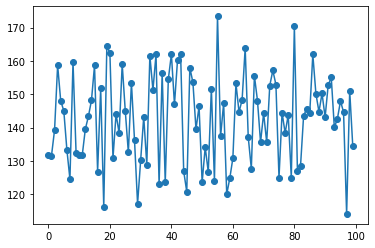

In [22]:
plt.plot(fitness_list, 'o-')

## Ant Colony  Optimization

https://github.com/rochakgupta/aco-tsp

In [23]:
import math
import random
from model.base_model import Model

class MyACOModel(Model):
    def __init__(self):
        super().__init__()

    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            roulette_wheel = 0.0
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            heuristic_total = 0.0
            for unvisited_node in unvisited_nodes:
                heuristic_total += self.edges[self.tour[-1]][unvisited_node].weight
            for unvisited_node in unvisited_nodes:
                roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
            random_value = random.uniform(0.0, roulette_wheel)
            wheel_position = 0.0
            for unvisited_node in unvisited_nodes:
                wheel_position += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                if wheel_position >= random_value:
                    return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    def init(self, nodes, *args):
        super().init(nodes)
        mode, colony_size, elitist_weight, min_scaling_factor, alpha, beta,  rho, pheromone_deposit_weight, initial_pheromone, labels = args

        self.mode = mode[0]
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.num_nodes = len(nodes)
        self.nodes = nodes

        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _acs(self, max_it):
        for step in range(0, max_it):
#             print('[step]', step)
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
                    self.fitness_list.append(ant.distance)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _elitist(self, max_it):
        for step in range(0, max_it):
#             print('[step]', step)
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
                    self.fitness_list.append(ant.distance)
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def fit(self, max_it=1000):
        """
        Execute simulated annealing algorithm.
        """
        # Initialize with the greedy solution.
        if self.mode == 'ACS':
            self._acs(max_it)
        elif self.mode == 'Elitist':
            self._elitist(max_it)
        else:
            print("Un supported")
#         print('Sequence : <- {0} ->'.format(' - '.join(str(self.labels[i]) for i in self.global_best_tour)))
#         print('Total distance travelled to complete the tour : {0}\n'.format(round(self.global_best_distance, 2)))

        return self.global_best_tour, self.fitness_list

In [24]:
tsp_file = './template/data/simple/ulysses16.tsp'

In [25]:
# Set hypter-parameters
mode='ACS', 
colony_size=10
elitist_weight=1.0
min_scaling_factor=0.001
alpha=1.0
beta=3.0
rho=0.1
pheromone_deposit_weight=1.0
initial_pheromone=1.0
labels = None

In [26]:
model = MyACOModel()
best_solution, fitness_list, time = TSP_Bench(tsp_file, model, mode, colony_size, elitist_weight, min_scaling_factor, alpha, beta, rho, pheromone_deposit_weight, initial_pheromone, labels, max_it=1000, timeout=300)

[*] [Node] 16, [Best] 74.1087359581531
[*] Running for: 1.61 seconds



## Your Smart Model

In [27]:
import math
import random
from model.base_model import Model

class MyModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)
        self.log("Nothing to initialize in your model now")

    def fit(self, max_it):
        """
        Put your iteration process here.
        """
        self.log("Naive Random Solution")
        self.best_solution = np.random.permutation(self.N).tolist()
        self.fitness_list.append(self.fitness(self.best_solution))

        return self.best_solution, self.fitness_list

## Test your Model

In [28]:
tsp_problem = './template/data/simple/ulysses16.tsp'

In [29]:
model = MyModel()
best_solution, fitness_list, time = TSP_Bench(tsp_file, model)

[MyModel] Nothing to initialize in your model now
[MyModel] Naive Random Solution
[*] [Node] 16, [Best] 149.95613345077442
[*] Running for: 0.00 seconds



# Test All Dataset

In [30]:
for root, _, files in os.walk('./template/data'):
    if(files):
        for f in files:
            print(str(root) + "/" + f)

./template/data/medium/pcb442.tsp
./template/data/medium/a280.tsp
./template/data/hard/dsj1000.tsp
./template/data/simple/att48.tsp
./template/data/simple/ulysses16.tsp
./template/data/simple/st70.tsp


In [31]:
def plot_results(best_solutions, times, title):
    fig = plt.figure()
    nodes = [len(s) for s in best_solutions]
    data = np.array([[node, time] for node, time in sorted(zip(nodes, times))])
    plt.plot(data[:, 0], data[:, 1], 'o-')
    fig.suptitle(title, fontsize=20)

In [32]:
tsp_path = './template/data'

In [33]:
model = MyRandomModel()

print("Random Search")
best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model)

Random Search
[*] ./template/data/medium/pcb442.tsp
[*] [Node] 442, [Best] 726804.3180499345
[*] Running for: 0.30 seconds

[*] ./template/data/medium/a280.tsp
[*] [Node] 280, [Best] 30377.079411308096
[*] Running for: 0.18 seconds

[*] ./template/data/hard/dsj1000.tsp
[*] [Node] 1000, [Best] 532033547.526717
[*] Running for: 0.71 seconds

[*] ./template/data/simple/att48.tsp
[*] [Node] 48, [Best] 114552.11880841342
[*] Running for: 0.05 seconds

[*] ./template/data/simple/ulysses16.tsp
[*] [Node] 16, [Best] 107.55064433885224
[*] Running for: 0.04 seconds

[*] ./template/data/simple/st70.tsp
[*] [Node] 70, [Best] 3006.0125566251013
[*] Running for: 0.06 seconds



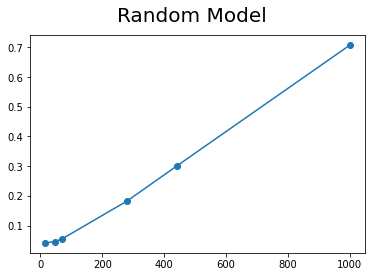

In [34]:
plot_results(best_solutions, times, "Random Model")

In [35]:
# Set hypter-parameters
mode='ACS', 
colony_size=10
elitist_weight=1.0
min_scaling_factor=0.001
alpha=1.0
beta=3.0
rho=0.1
pheromone_deposit_weight=1.0
initial_pheromone=1.0
labels = None

In [36]:
model = MyACOModel()

print("Ant Colony Optimization")
best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model, mode, colony_size, elitist_weight, min_scaling_factor, alpha, beta, rho, pheromone_deposit_weight, initial_pheromone, labels, max_it=100, timeout=600)

Ant Colony Optimization
[*] ./template/data/medium/pcb442.tsp
[*] [Node] 442, [Best] 81773.39944759021
[*] Running for: 437.55 seconds

[*] ./template/data/medium/a280.tsp
[*] [Node] 280, [Best] 3402.3354165651604
[*] Running for: 122.83 seconds

[*] ./template/data/hard/dsj1000.tsp
[*] Timeout -3
[*] Running for: 600.01 seconds

[*] ./template/data/simple/att48.tsp
[*] [Node] 48, [Best] 37903.563183654456
[*] Running for: 1.60 seconds

[*] ./template/data/simple/ulysses16.tsp
[*] [Node] 16, [Best] 74.61480359572822
[*] Running for: 0.18 seconds

[*] ./template/data/simple/st70.tsp
[*] [Node] 70, [Best] 758.1364540871836
[*] Running for: 3.71 seconds



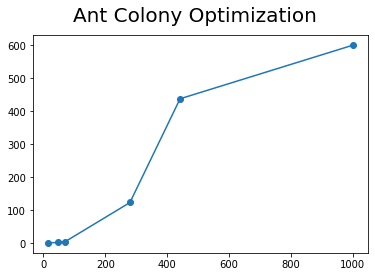

In [37]:
plot_results(best_solutions, times, "Ant Colony Optimization")